allCarriers:   [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242

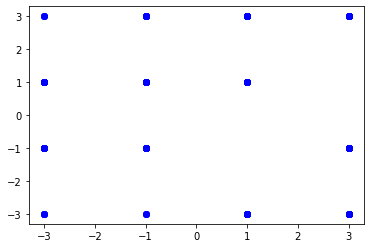

In [45]:
# %%
#!pip3 install matplotlib
#!pip3 install numpy
#!pip3 install scipy
#!pip3 install statsmodels

from audioop import rms
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.interpolate
from scipy.signal import butter,filtfilt
from statsmodels.distributions.empirical_distribution import ECDF
import math
import os
import time

# %%
# Max number of samples to be saved
# number of samples either limited by SAMPLES or by len(bits)
MAX_SAMPLES = 1
filename_raw_bits = 'raw_bit_sequence_training_50000.npy'

file_id_output = 2

filename_papr_data = "papr_data_" + str(file_id_output) + ".dat"
filename_raw_data_real = "raw_data_real_" + str(file_id_output) + ".dat"
filename_raw_data_imaginary = "raw_data_imaginary_" + str(file_id_output) + ".dat"

K = 256 # number of OFDM subcarriers
CLIPPING_AND_FILTERING_ACTIVE = True
CLIPPING_RATIO = 1.4
title_info = "16qam_" + str(K) + "_subcarriers_clipping_and_filtering"


# read only
NUMBER_OF_CLIPPED_TIME_VALUES = 0

# %% [markdown]
# The length of the cyclic prefix (CP) denotes the number of samples that are copied from the end of the modulated block to the beginning, to yield a cyclic extension of the block. There is a dedicated article on the CP of OFDM which treats its application in more detail.

# %%
CP = K//4  # length of the cyclic prefix: 25% of the block

# %% [markdown]
# The number of pilots P in the OFDM symbol describes, how many carriers are used to transmit known information (i.e. pilots). Pilots will be used at the receiver to estimate the wireless channel between transmitter and receiver. Further, we also define the value that each pilots transmits (which is known to the receiver).

# %%
P = 8 # number of pilot carriers per OFDM block
pilotValue = 3+3j # The known value each pilot transmits

# %% [markdown]
# Now, let us define some index sets that describe which carriers transmit pilots and which carriers contain payload.

# %%
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])

pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)

print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
#plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
#plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'r', label='data')
#plt.legend(["pilot", "data"])

# %% [markdown]
# Let's define the modulation index μ and the corresponding mapping table. We consider 16QAM transmission, i.e. we have μ=4 bits per symbol. Furthermore, the mapping from groups of 4 bits to a 16QAM constellation symbol shall be defined in mapping_table.

# %%
mu = 4 # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                #plt.plot(Q.real, Q.imag, 'bo')
                #plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

# %% [markdown]
# Above, we have plotted the 16QAM constellation, along with the bit-labels. Note the Gray-mapping, i.e. two adjacent constellation symbols differ only by one bit and the other 3 bits remain the same. This technique helps to minimize bit-errors, in case a wrong constellation symbol is detected: Most probably, symbol errors are "off-by-one" errors, i.e. a symbol next to the correct symbol is detected. Then, only a single bit-error occurs.
# 
# The demapping table is simply the inverse mapping of the mapping table:

# %%
demapping_table = {v : k for k, v in mapping_table.items()}

# %% [markdown]
# Let us now define the wireless channel between transmitter and receiver. Here, we use a two-tap multipath channel with given impulse response channelResponse. Also, we plot the corresponding frequency response. As we see, the channel is frequency-selective. Further, we define the signal-to-noise ratio in dB, that should occur at the receiver.

# %%
channelResponse = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)
#plt.plot(allCarriers, abs(H_exact))

SNRdb = 25  # signal to noise-ratio in dB at the receiver 


# load bits from file
with open(filename_raw_bits, 'rb') as myfile:
    totalbits = np.load(myfile)

number_of_samples = min(MAX_SAMPLES, int(len(totalbits) / payloadBits_per_OFDM))
print("Expected number of samples generated from raw bits: " + str(number_of_samples))
time.sleep(5)

i = 1
bits = totalbits[i*payloadBits_per_OFDM:i*payloadBits_per_OFDM+payloadBits_per_OFDM]

# %% [markdown]
# The bits are now sent to a serial-to-parallel converter, which groups the bits for the OFDM frame into a groups of mu bits (i.e. one group for each subcarrier):

# %%
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))
bits_SP = SP(bits)
#print ("First 5 bit groups")
#print (bits_SP[:5,:])

# %% [markdown]
# Now, the bits groups are sent to the mapper. The mapper converts the groups into complex-valued constellation symbols according to the mapping_table.

# %%
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)
#print ("First 5 QAM symbols and bits:")
#print (bits_SP[:5,:])
#print (QAM[:5])

# %% [markdown]
# The next step (which is not shown in the diagram) is the allocation of different subcarriers with data and pilots. For each subcarrier we have defined wether it carries data or a pilot by the arrays dataCarriers and pilotCarriers. Now, to create the overall OFDM data, we need to put the data and pilots into the OFDM carriers:

# %%
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
OFDM_data = OFDM_symbol(QAM)
#print ("Number of OFDM carriers in frequency domain: ", len(OFDM_data))

# %% [markdown]
# Now, the OFDM carriers contained in OFDM_data can be transformed to the time-domain by means of the IDFT operation.

# %%
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)
#print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))

## now plot the constellation diagram to control the noise before clipping and filtering
def DFT(OFDM_time):
    return np.fft.fft(OFDM_time)
OFDM_data_for_constellation = DFT(OFDM_time)

for value in OFDM_data_for_constellation:
    plt.plot(value.real, value.imag, 'bo')

In [46]:
# OFDM_time is one complex OFDM sample which will correspond to one PAPR value

# if clipping is active, do the clipping now
if CLIPPING_AND_FILTERING_ACTIVE:
    
    
    def clip_array(clipping_ratio, array, clipped_values_count):
        # normalized clipping
        # level, which we call the clipping ratio (CR = A/α, where α is
        # the rms level of the OFDM signal). A CR of 1.4 denotes that
        # the clipping level is about 3 dB higher than the rms level.
        rms_ofdm_time = np.sqrt(np.sum(np.square(array) / len(array)))
        #print(rms_ofdm_time)
        CLIPPING_THRESHOLD = clipping_ratio * rms_ofdm_time                

        arr_i = 0
        for value in array:
            if value > CLIPPING_THRESHOLD:
                value = CLIPPING_THRESHOLD
                clipped_values_count = clipped_values_count + 1

            array[arr_i] = value
            arr_i = arr_i + 1        
        
        return (array, clipped_values_count)
    
    array_to_be_clipped = np.real(OFDM_time)
    (clipped_values_real, NUMBER_OF_CLIPPED_TIME_VALUES) = clip_array(CLIPPING_RATIO, array_to_be_clipped, NUMBER_OF_CLIPPED_TIME_VALUES)

    array_to_be_clipped = np.imag(OFDM_time)
    (clipped_values_imag, NUMBER_OF_CLIPPED_TIME_VALUES) = clip_array(CLIPPING_RATIO, array_to_be_clipped, NUMBER_OF_CLIPPED_TIME_VALUES)                       
    
    # save clipped data in OFDM_time        
    for i in range(len(clipped_values_real)):
        OFDM_time = np.append(OFDM_time, np.complex(clipped_values_real[i], clipped_values_imag[i]))    

      

C:\Users\jonas\AppData\Local\Temp/ipykernel_14044/1258689036.py:35: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  OFDM_time = np.append(OFDM_time, np.complex(clipped_values_real[i], clipped_values_imag[i]))


In [47]:
print(len(OFDM_time))
print(NUMBER_OF_CLIPPED_TIME_VALUES)

512
50


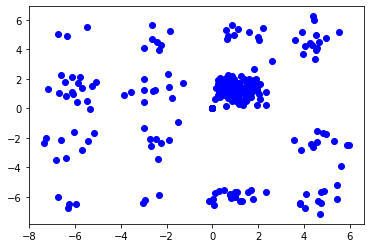

In [48]:
## now plot the constellation diagram to control the noise after clipping
def DFT(OFDM_time):
    return np.fft.fft(OFDM_time)
OFDM_data_for_constellation = DFT(OFDM_time)

for value in OFDM_data_for_constellation:
    plt.plot(value.real, value.imag, 'bo')

In [49]:
# if clipping was active, do the filtering now
# Filter requirements.        
fs = 300e3       # sample rate, Hz
cutoff = 120e3      # desired cutoff frequency of the filter [Hz]        
order = 2       # sine wave can be approx represented as quadratic

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

OFDM_time = butter_lowpass_filter(OFDM_time, cutoff, fs, order)  

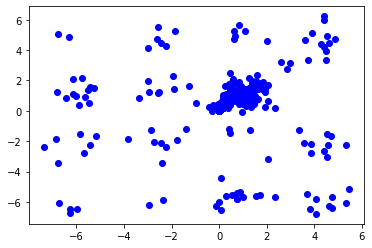

In [50]:
## now plot the constellation diagram to control the noise after clipping and filtering
def DFT(OFDM_time):
    return np.fft.fft(OFDM_time)
OFDM_data_for_constellation = DFT(OFDM_time)

for value in OFDM_data_for_constellation:
    plt.plot(value.real, value.imag, 'bo')

In [51]:
# compute the PAPR of the time-domain signal sample
power_peak = max(np.square(abs(OFDM_time)))
power_mean = np.mean(np.square(abs(OFDM_time)), dtype=np.float64)

# decibel above average power
PAPR = 10* np.log10(power_peak / power_mean)

print("PAPR of sample: " + str(PAPR) + " dB")

PAPR of sample: 9.129204327878197 dB
